对小目标进行分割

19    Right-Caudate

20    Right-Putamen

In [1]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

import torch
import os

/root/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_gpu=0
os.environ['CUDA_VISIBLE_DEVICES'] = '%d' % m_gpu
torch.cuda.set_device(m_gpu)
torch.cuda.is_available()
torch.cuda.current_device()
device = torch.device(torch.cuda.current_device())
print("device now: ", device)

device now:  cuda:0


In [3]:
from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

In [4]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

def accuracy_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    total_pixels = 128 * 128
    correct_pixels = torch.sum(y_pred == y_true)
    accuracy = correct_pixels / total_pixels
    return accuracy.item()

# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits        

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)
    acc = accuracy_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score,
            'acc': acc}

In [12]:
import example_data.oasis
label = 10

d_support = example_data.oasis.OASISDataset('support', label=label)
d_test = example_data.oasis.OASISDataset('test', label=label)

support_images, support_labels = zip(*itertools.islice(d_support, 10))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

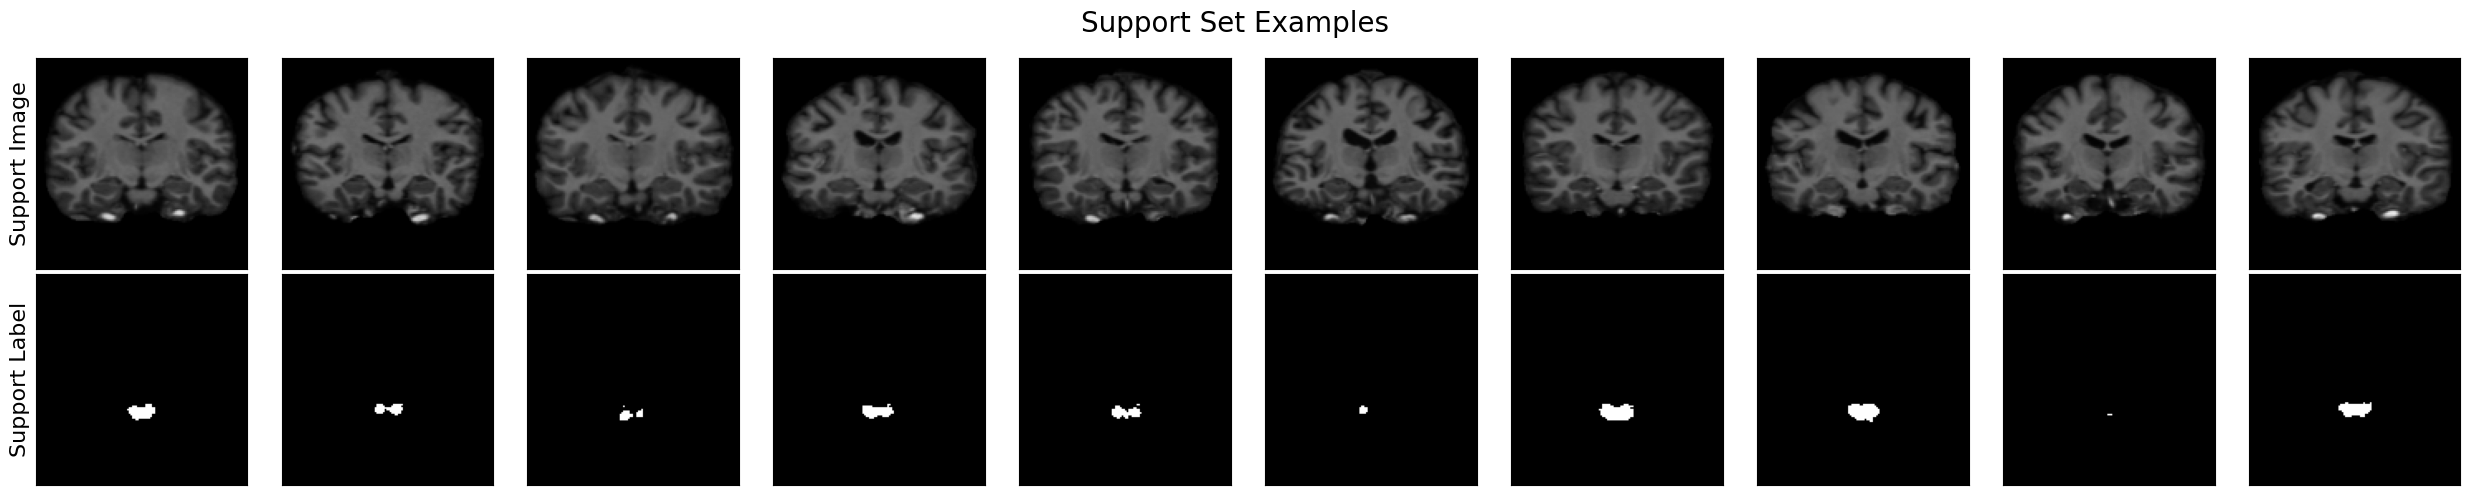

In [13]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

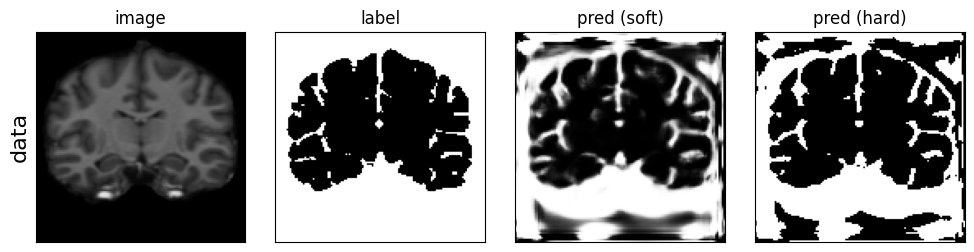

In [7]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)

# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

torch.Size([1, 128, 128])


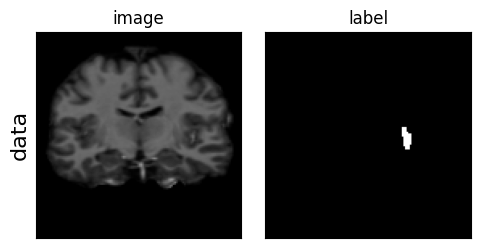

In [8]:
print(image.size())
visualize_tensors({'data': [image, label]}, col_wrap=2, col_names=['image', 'label'])

定量评估

In [9]:
from collections import defaultdict

n_predictions = 100

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)
    
# visualize the results, along with their scores
scores = results.pop('score')    
print("Dice score: ", np.array(scores).mean())
acc = results.pop('acc')
print("Pixel accuracy: ", np.array(acc).mean())

100%|██████████| 100/100 [00:00<00:00, 106.91it/s]

Dice score:  0.77686627805233
Pixel accuracy:  0.998514404296875


  0%|          | 0/5 [00:00<?, ?it/s]

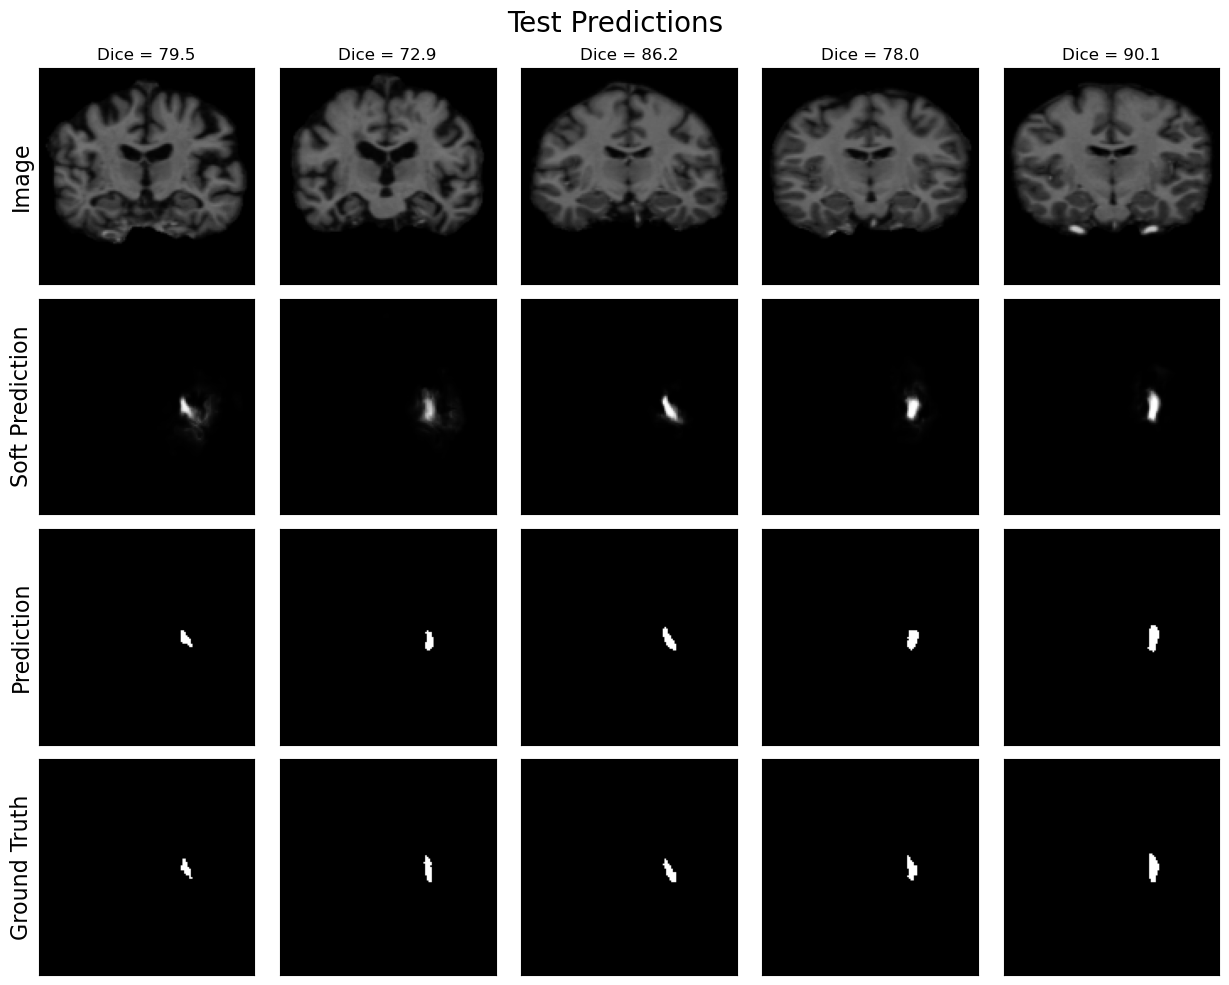

In [36]:
n_predictions = 5

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

scores = results.pop('score')
acc = results.pop('acc')
visualize_tensors(results, 
                  col_names=[f'Dice = {100*s:.1f}' for s in scores], 
                  title='Test Predictions', 
                  col_wrap=n_predictions)